In [3]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import time
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
from riotwatcher import RiotWatcher
import requests
from scipy.stats import zscore

api_file = os.path.join('..','..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

## Load hero data
and make cleaned_df with only desired information in it, formatted properly

In [3]:
champ_file=os.path.join('lol_data','version9.10.1_champion.json')
with open(champ_file,'r') as fin:
    champs_data=json.load(fin)
champ_vocab=[]
champ_names=[]
for name,champ in champs_data['data'].items():
    champ_vocab.append(champ['key'])
    champ_names.append(name)
champ_vocab = [int(i) for i in champ_vocab]
print(len(champ_vocab))

144


In [4]:
champ_df=pd.DataFrame(champs_data['data']).T
champ_df['key']=champ_df['key'].astype(int)
champ_df = champ_df.set_index('key')
#use pandas to expand dict of info and store in same df
champ_df = champ_df.join(champ_df['info'].apply(pd.Series))
champ_df = champ_df.join(champ_df['stats'].apply(pd.Series))
champ_df.head(1)

,blurb,id,image,info,name,partype,stats,tags,title,version,...,hpregen,hpregenperlevel,mpregen,mpregenperlevel,crit,critperlevel,attackdamage,attackdamageperlevel,attackspeedperlevel,attackspeed
key,,,,,,,,,,,,,,,,,,,,,
266,Once honored defenders of Shurima against the ...,Aatrox,"{'full': 'Aatrox.png', 'sprite': 'champion0.pn...","{'attack': 8, 'defense': 4, 'magic': 3, 'diffi...",Aatrox,Blood Well,"{'hp': 580, 'hpperlevel': 90, 'mp': 0, 'mpperl...","[Fighter, Tank]",the Darkin Blade,9.10.1,...,3.0,0.75,0.0,0.0,0.0,0.0,60.0,5.0,2.5,0.651


In [5]:
champ_df.describe()

,attack,defense,magic,difficulty,hp,hpperlevel,mp,mpperlevel,movespeed,armor,...,hpregen,hpregenperlevel,mpregen,mpregenperlevel,crit,critperlevel,attackdamage,attackdamageperlevel,attackspeedperlevel,attackspeed
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,144.000000,144.000000,144.0,144.0,144.000000,144.000000,144.000000,144.000000
mean,5.493056,4.750000,5.437500,5.715278,553.666389,88.355903,308.258750,32.399306,336.409722,30.032000,...,6.592014,0.660069,8.384472,0.557118,0.0,0.0,59.338524,3.253865,2.459979,0.648097
std,2.763388,2.077182,2.729581,2.057438,38.477250,6.697679,118.344494,16.667415,7.692893,6.732314,...,1.720340,0.162324,8.413705,0.282157,0.0,0.0,6.027883,0.601399,0.815094,0.036148
min,1.000000,1.000000,1.000000,1.000000,340.000000,65.000000,0.000000,0.000000,315.000000,17.040000,...,2.500000,0.300000,0.000000,0.000000,0.0,0.0,40.368000,1.500000,0.000000,0.475000
25%,3.000000,3.000000,3.000000,4.000000,531.500000,85.000000,276.380000,25.000000,330.000000,24.609000,...,5.500000,0.550000,6.675000,0.437500,0.0,0.0,55.000000,3.000000,2.000000,0.625000
50%,6.000000,5.000000,6.000000,6.000000,560.000000,88.000000,322.200000,37.000000,335.000000,30.000000,...,7.000000,0.600000,7.516000,0.625000,0.0,0.0,60.000000,3.170800,2.500000,0.644000
75%,8.000000,6.000000,8.000000,7.000000,582.060000,92.000000,377.250000,42.250000,340.000000,35.000000,...,8.000000,0.750000,8.010500,0.800000,0.0,0.0,64.000000,3.500000,3.000000,0.665000
max,10.000000,10.000000,10.000000,10.000000,625.640000,112.000000,500.000000,67.000000,355.000000,47.000000,...,10.000000,1.750000,50.000000,1.000000,0.0,0.0,69.180000,5.000000,6.000000,0.800000


In [6]:
info_columns = list(champ_df['info'].head(1))[0].keys()
stat_dict = list(champ_df['stats'].head(1))[0]
print(stat_dict)
bad_stats_keys=['mp','mpperlevel','mpregen','mpregenperlevel','crit','critperlevel']
for key in bad_stats_keys:
    print(stat_dict.pop(key))
stat_columns = list(stat_dict.keys())
print(stat_columns)

{'hp': 580, 'hpperlevel': 90, 'mp': 0, 'mpperlevel': 0, 'movespeed': 345, 'armor': 38, 'armorperlevel': 3.25, 'spellblock': 32.1, 'spellblockperlevel': 1.25, 'attackrange': 175, 'hpregen': 3, 'hpregenperlevel': 0.75, 'mpregen': 0, 'mpregenperlevel': 0, 'crit': 0, 'critperlevel': 0, 'attackdamage': 60, 'attackdamageperlevel': 5, 'attackspeedperlevel': 2.5, 'attackspeed': 0.651}
0
0
0
0
0
0
['hp', 'hpperlevel', 'movespeed', 'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel', 'attackrange', 'hpregen', 'hpregenperlevel', 'attackdamage', 'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed']


In [7]:
#convert tags to one hot using get_dummies and sum 
#    (some champs have two tags, some have one)
champ_tag_df=pd.DataFrame()
champ_tag_df[0] = pd.get_dummies(champ_df['tags'].apply(pd.Series)[0]).agg(np.array,axis=1)
champ_tag_df[1] = pd.get_dummies(champ_df['tags'].apply(pd.Series)[1]).agg(np.array,axis=1)
champ_tag_df['one_hot_tags'] = champ_tag_df.agg('sum',axis=1)

In [8]:
#cleaned df (for now) has only info or one hot tags.
champ_cleaned_df=pd.DataFrame()
#aggregate info to make into single column with list elements
champ_cleaned_df['info']=champ_df.filter(items=info_columns).apply(zscore).agg(np.array,axis=1)
champ_cleaned_df['stats']=champ_df.filter(items=stat_columns).apply(zscore).agg(np.array,axis=1)
champ_cleaned_df['one_hot_tags']=champ_tag_df['one_hot_tags']
champ_cleaned_df.sort_index(inplace=True)
champ_cleaned_df['index']=list(range(len(champ_cleaned_df.index)))
print(champ_cleaned_df.head(10))
champ_cleaned_df.describe()

                                                  info  \
key                                                      
1    [-1.268460070535441, -0.8454281663398984, 1.67...   
2    [1.2735036493447272, 0.12077545233427119, -0.8...   
3    [-1.6315977448040366, 2.536284499019695, 0.206...   
4    [0.18409062653894084, -1.328529975676983, 0.20...   
5    [0.9103659750761318, 0.6038772616713559, -0.89...   
6    [0.9103659750761318, 0.12077545233427119, -0.8...   
7    [-1.6315977448040366, -0.36232635700281357, 1....   
8    [-1.268460070535441, 0.6038772616713559, 0.942...   
9    [-1.268460070535441, -0.8454281663398984, 1.30...   
10   [0.18409062653894084, 0.6038772616713559, 0.57...   

                                                 stats        one_hot_tags  \
key                                                                          
1    [-0.7737023084848982, -0.05332370318574956, -0...  [0, 0, 1, 0, 0, 0]   
2    [1.1364040170833432, 0.6958092976677209, 1.772...  [0, 1, 0, 0, 

,index
count,144.000000
mean,71.500000
std,41.713307
min,0.000000
25%,35.750000
50%,71.500000
75%,107.250000
max,143.000000


# Load data and put it into a TFRecords file
Do this to nicely handle the features that is a numpy array (blue_champs and red_champs)

In [4]:
#get all files in challenger_tier data folder, then sort by date
files = glob.glob(os.path.join('LOL_data','*','V9.10','*.csv'))
#files.sort(key=os.path.getmtime)
print(files)

['LOL_data/challenger_tier/V9.10/saved2019-05-28.csv', 'LOL_data/masters_tier/V9.10/saved2019-05-17.csv']


In [5]:
lol_df = None
for filename in files[-2:]:
    print(filename)
    tier = filename[9:-31]
    if tier=='challenger':
        tier_num=0
    elif tier=='masters':
        tier_num=1
    else:
        raise KeyError
    
    if type(lol_df)==None:
        lol_df = pd.read_csv(filename, usecols=range(1,24))
        lol_df['skill_level'] = tier_num
    else:
        new_df = pd.read_csv(filename,usecols=range(1,24))
        new_df['skill_level'] = tier_num
        lol_df = pd.concat([lol_df, new_df],ignore_index=True)
lol_df.describe()

LOL_data/challenger_tier/V9.10/saved2019-05-28.csv
LOL_data/masters_tier/V9.10/saved2019-05-17.csv


,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,red_champs0,blue_champs1,red_champs1,blue_champs2,red_champs2,blue_champs3,red_champs3,blue_champs4,red_champs4,skill_level
count,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,...,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000
mean,0.493564,50667.496270,50894.768367,5.239075,5.249990,0.856535,0.857602,1.333948,1.499933,0.424299,...,127.025784,128.486014,128.615937,128.043627,127.839944,128.491395,128.608868,127.264297,126.917019,0.724167
std,0.499959,15476.016762,15707.437316,3.728810,3.767128,1.113665,1.109356,1.214319,1.268132,0.613052,...,130.100459,130.826929,131.269630,130.474368,130.717533,130.736454,131.399606,130.096694,129.770730,0.446933
min,0.000000,3313.000000,3345.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,40860.000000,40873.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,0.000000
50%,0.000000,51309.000000,51651.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,84.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,1.000000
75%,1.000000,60938.000000,61422.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,145.000000,154.000000,154.000000,154.000000,150.000000,154.000000,154.000000,150.000000,145.000000,1.000000
max,1.000000,136791.000000,133619.000000,15.000000,15.000000,13.000000,12.000000,7.000000,9.000000,5.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,1.000000


In [11]:
#merge info and tag columns for all champs
#insert filler merge to allow suffixes to trigger
#set suffix to false false so it throws a keyerror if merge has been performed
lol_df['info']=np.nan
lol_df['one_hot_tags']=np.nan
lol_df['index']=np.nan
lol_df['stats']=np.nan
for i in range(5):
    lol_df=pd.merge_ordered(lol_df,champ_cleaned_df,
                 left_on='blue_champs'+str(i),
                 right_on='key',
                 how='inner',
                 suffixes=('','_blue_champs'+str(i)))
    lol_df=pd.merge_ordered(lol_df,champ_cleaned_df,
                 left_on='red_champs'+str(i),
                 right_on='key',
                 how='inner',
                 suffixes=('','_red_champs'+str(i)))
    
lol_df = lol_df.drop(columns=['index',
                       'info',
                       'one_hot_tags',
                       'stats'])
lol_df = lol_df.sample(frac=1).reset_index(drop=True)


In [12]:
len(lol_df['stats_blue_champs4'].head(1)[0])

14

In [13]:
lol_df.describe()

,blue_win,blue_gold,red_gold,blue_tower_kills,red_tower_kills,blue_inhibitor_kills,red_inhibitor_kills,blue_dragon_kills,red_dragon_kills,blue_baron_kills,...,index_blue_champs0,index_red_champs0,index_blue_champs1,index_red_champs1,index_blue_champs2,index_red_champs2,index_blue_champs3,index_red_champs3,index_blue_champs4,index_red_champs4
count,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,...,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.000000,441677.00000,441677.000000
mean,0.493564,50667.496270,50894.768367,5.239075,5.249990,0.856535,0.857602,1.333948,1.499933,0.424299,...,74.317531,74.267349,74.704904,74.666166,74.605137,74.434453,74.745067,74.618291,74.34902,74.279444
std,0.499959,15476.016762,15707.437316,3.728810,3.767128,1.113665,1.109356,1.214319,1.268132,0.613052,...,42.315103,42.340806,42.379948,42.446029,42.333966,42.422150,42.361370,42.444383,42.31716,42.277380
min,0.000000,3313.000000,3345.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,40860.000000,40873.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.00000,38.000000
50%,0.000000,51309.000000,51651.000000,5.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,75.000000,74.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.00000,75.000000
75%,1.000000,60938.000000,61422.000000,9.000000,9.000000,1.000000,1.000000,2.000000,2.000000,1.000000,...,112.000000,111.000000,113.000000,113.000000,113.000000,112.000000,113.000000,113.000000,112.00000,111.000000
max,1.000000,136791.000000,133619.000000,15.000000,15.000000,13.000000,12.000000,7.000000,9.000000,5.000000,...,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.00000,143.000000


In [17]:
sns.set_style('ticks')
champ_sum = np.concatenate((lol_df['blue_champs0'],lol_df['blue_champs1'],lol_df['blue_champs2'],
            lol_df['blue_champs3'],lol_df['blue_champs4'],lol_df['red_champs0'],
            lol_df['red_champs1'],lol_df['red_champs2'],lol_df['red_champs3'],
            lol_df['red_champs4']),axis=None)

unique_all, counts_all= np.unique(champ_sum, return_counts=True)
print(len(unique))

144


### Plot hero counts for each slot to check if slot affects hero occurance
(it does somewhat, but not too much)

In [34]:
count_df=pd.DataFrame()
unique=[];counts=[]
team=[];champ_slot=[]
for i in range(5):
    unique_single,counts_single=np.unique(lol_df['blue_champs'+str(i)],return_counts=True)
    unique.extend(unique_single)
    counts.extend(counts_single)
    team.extend(['blue']*len(counts_single))
    champ_slot.extend([i]*len(counts_single))
    
    unique_single,counts_single=np.unique(lol_df['red_champs'+str(i)],return_counts=True)
    unique.extend(unique_single)
    counts.extend(counts_single)
    team.extend(['red']*len(counts_single))
    champ_slot.extend([i]*len(counts_single))
count_df['unique']=unique
count_df['counts']=counts
count_df['team']=team
count_df['champ_slot']=champ_slot
count_df['error']=np.sqrt(count_df['counts'])

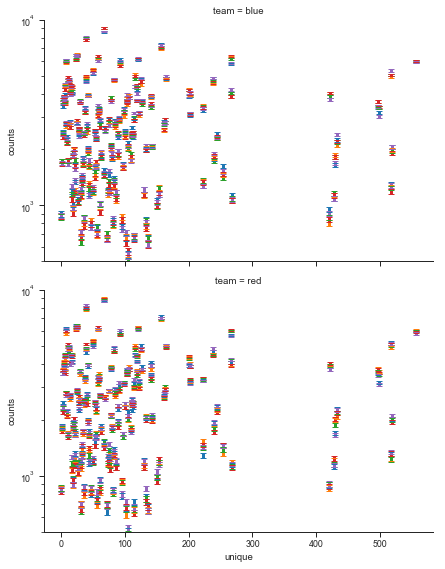

In [84]:
sns.set_style('ticks')
g = sns.FacetGrid(count_df,row='team',hue='champ_slot',
                  height=4, aspect=1.6,ylim=[500,10000])
fgrid = g.map(plt.errorbar,'unique','counts','error',fmt='none',capsize=3,linewidth=3)
fgrid.set(yscale='log')
plt.show()

## Plot various features of matches to check data validity

### Distribution of hero occurence
This distribution shows that the pick rate of characters is heavily skewed with a few heroes being very frequently picked.

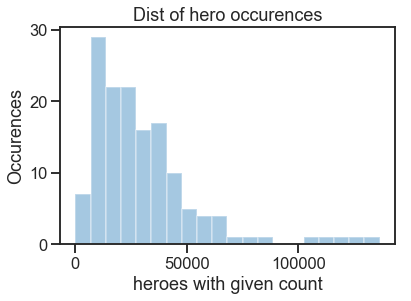

In [87]:
sns.set_context('talk')
sns.distplot(counts,bins=20,norm_hist=False,kde=False)
plt.xlabel("heroes with given count")
plt.ylabel('Occurences')
plt.title('Dist of hero occurences')
plt.show()

### Distribution of gold grouped by win
Distributions for red side win/loss and blue side win/loss look normalish and symmetric. 

There seems to be a small distribution of games that have slightly lower gold outcomes. This could perhaps be explained by games in which one team surrendered.

It also looks like therer could be a long tail of games in which the losing team has a score near what you would expect for them winning and vice versa. This may be due to a comeback for the ultimate winners.

There are about 4000 games per group with very low gold. This likely indicates a bad game we should throw out. They may correspond to games that lasted <10minutes with all players only gaining passive gold. ->5 * (500 g/hero +2.04g/s *60 s/min (5 mins - 1.67 mins)) = 5000 gold

***Altogether these distributions demonstrate that win may not so bad of a target, at least for LOL due to 1) the surrender mechanic and 2) comebacks***

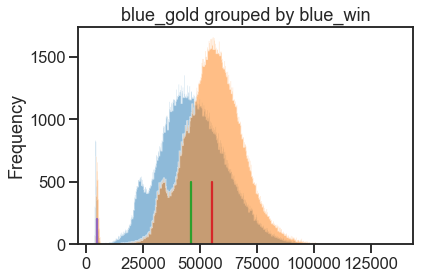

mean:  blue_win
0    46248.847265
1    55201.376837
Name: blue_gold, dtype: float64 
skew: blue_win
0    0.026362
1   -0.501463
Name: blue_gold, dtype: float64


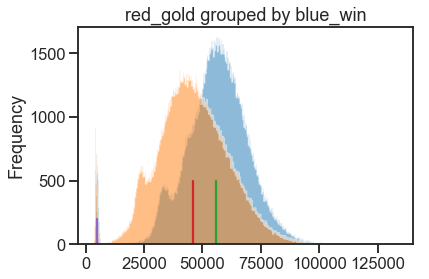

mean:  blue_win
0    55864.264211
1    45795.675723
Name: red_gold, dtype: float64 
skew: blue_win
0    0.026362
1   -0.501463
Name: blue_gold, dtype: float64


In [115]:
lol_df.groupby('blue_win')['blue_gold'].plot.hist(bins=600,histtype='stepfilled',alpha=0.5)
mean = lol_df.groupby('blue_win')['blue_gold'].mean()
skew = lol_df.groupby('blue_win')['blue_gold'].skew()
plt.plot([mean,mean],[0,500])
plt.plot([5000,5000],[0,200])
plt.title('blue_gold grouped by blue_win')
plt.show()
print('mean: ',mean,'\nskew:',skew)

lol_df.groupby('blue_win')['red_gold'].plot.hist(bins=600,histtype='stepfilled',alpha=0.5)
mean = lol_df.groupby('blue_win')['red_gold'].mean()
skew = lol_df.groupby('blue_win')['blue_gold'].skew()
plt.plot([mean,mean],[0,500])
plt.plot([5000,5000],[0,200])
plt.title('red_gold grouped by blue_win')
plt.show()
print('mean: ',mean,'\nskew:',skew)

### Distribution of gold grouped by win, region
Distributions grouped by region and win show some differences. Especially KR (korea) has a much sharper lower peak (which I attributed to surrenders)and also a sharper lower peak in win gold (which I attributed to comebacks).

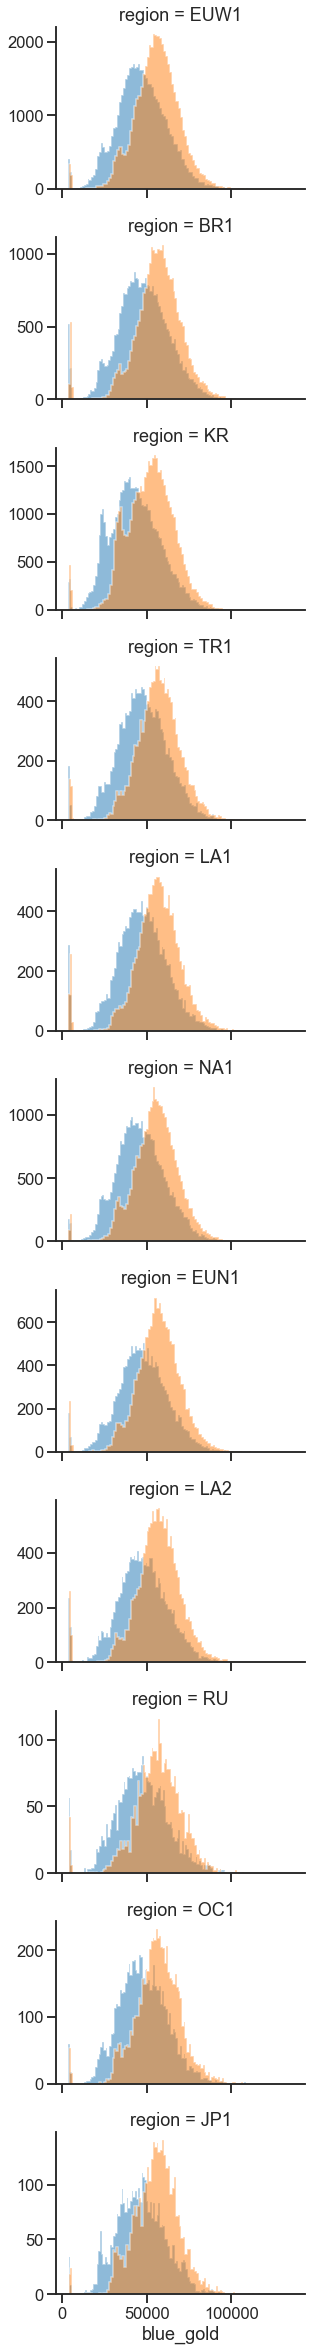

In [114]:
g = sns.FacetGrid(lol_df,row='region',hue='blue_win',
                  sharey=False,palette=sns.color_palette(),
                  height=3, aspect=1.6,legend_out=True)
g = g.map(plt.hist,'blue_gold',
          histtype='stepfilled',alpha=0.5,bins=100)
#.plot.hist(bins=300,histtype='step',alpha=0.5)
#plt.plot()